In [6]:
import pandas as pd
import glob
import os
import pytz
import CleanWxData as wx

import matplotlib.pyplot as plt
%matplotlib notebook

In [23]:
import settings
Glacier='Wolverine'
Station='990'

data_columns, general_data_columns, out_date_format, precip_columns, precip_gage_change, primary_temp_column, temp_columns, timezone, wind_col, wind_dir_columns = settings.get_settings(settings.Glacier, settings.Station)

In [24]:
if (Glacier + Station== "Gulkana1480"):
    par_dir=r"Q:\Project Data\GlacierData\Benchmark_Program\Data/" +Glacier+ r'/AllYears/Wx/Raw/telemeteredNWIS'
if Glacier + Station =="Wolverine990":
    par_dir=r"Q:\Project Data\GlacierData\Benchmark_Program\Data\Wolverine\AllYears\Wx\Raw\telemeteredNWIS\Historical_1995to2017"
if Glacier + Station=="Wolverine370":
    par_dir=r"Q:\Project Data\GlacierData\Benchmark_Program\Data\Wolverine\AllYears\Wx\Raw\telemeteredNWIS\Historical_1997to2017StreamGage"
if Glacier + Station=='SouthCascade1640':
    par_dir=r'Q:\Project Data\GlacierData\Benchmark_Program\Data\SouthCascade\AllYears\Wx\Raw\telemeteredNWIS_gage_SCGMiddleTarn'
if Glacier + Station=='SouthCascade560':
    par_dir=r'Q:\Project Data\GlacierData\Benchmark_Program\Data\SouthCascade\AllYears\Wx\Raw\telemeteredNWIS_hut'

In [25]:
os.chdir(par_dir)
fls=glob.glob('*.csv')

In [26]:
#Remove the summary file if already made previously
fls.remove("NWIS_data_"+Glacier + Station+".csv")

In [27]:
pwd

'Q:\\Project Data\\GlacierData\\Benchmark_Program\\Data\\Wolverine\\AllYears\\Wx\\Raw\\telemeteredNWIS\\Historical_1995to2017'

In [28]:
alldat=pd.DataFrame()
for fl in fls:
    dat=pd.read_csv(fl, header=14)
    var_name=fl.replace(".csv", "")
    print(var_name)
    dat=dat[['ISO 8601 UTC', ' Value']]
    dat.rename(columns = {' Value': var_name}, inplace = True)
    if fl==fls[0]:
        alldat=alldat.append(dat)
        continue
    alldat=alldat.merge(dat, on='ISO 8601 UTC', how='outer')

StageCumulative
TAspirated1
TAspirated2
Tpassive1
Tpassive2
WindDir
WindGustSpeed
WindSpeed


In [29]:
alldat=alldat.rename(columns={'ISO 8601 UTC': "UTC_time"})

In [30]:
#Convert wind gust speed from mph to m/s!! (this is only @ Wolv 990)
if Glacier + Station == 'Wolverine990':
    alldat.WindGustSpeed=alldat.WindGustSpeed * 0.44704 #convert from mph to m/s

In [31]:
#Convert english units to metric @ gage
if Glacier +Station== 'Wolverine370':
    alldat.TipIncremental= alldat.TipIncremental * 0.0254 #convert from inches to meters of precip
    alldat.Discharge=alldat.Discharge * 0.0283168 #convert from ft3/s to m3/s

In [32]:
alldat['UTC_time']=pd.to_datetime(alldat.UTC_time, format='%Y-%m-%dT%H:%M:%SZ')

In [33]:
#Set timezone of known UTC column
alldat['UTC_time'].timezone='UTC'

#Create column for local time
local_timezone=pytz.timezone(timezone) #create local timezone object (e.g. AK time)

alldat=alldat.set_index('UTC_time')
#Create column for local time
local_timezone=pytz.timezone(timezone) #create local timezone object (e.g. AK time)

#Re-sort on time index
alldat=alldat.sort_index()

<IPython.core.display.Javascript object>


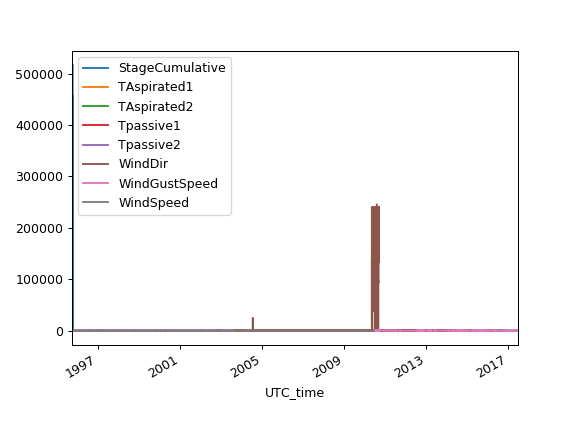

In [34]:
alldat.plot()

In [22]:
all.iplot(subplots=True, shape=(4,1), shared_xaxes=True)

AttributeError: 'builtin_function_or_method' object has no attribute 'iplot'

In [29]:
#Determine which years have cumulative precip, and which have incremental.
if Glacier + Station=='Wolverine370':
    alldat['month']=alldat.index.month
    alldat.loc[~alldat.month.isin([6,7,8,9]), 'TipIncremental']=pd.np.nan #first, set non-summer months to NAN
# alldat.loc['2001-01':'2001-08-08', 'TipIncremental']=pd.np.nan #this data looks bad; unknown

# incr_years=['2001', '2002', '2003' '2004']
# cum_years=[]
# bad_yrs=['2009', '2010', '2011']

In [30]:
if (Glacier + Station == 'SouthCascade1640') | (Glacier + Station == 'SouthCascade560'):
    fifteenmin_dat=pd.DataFrame()
    for col in alldat:
        fifteenmin_dat[col]=wx.create_15min_from_hourly_data(alldat, col)
alldat=fifteenmin_dat.copy()

<IPython.core.display.Javascript object>


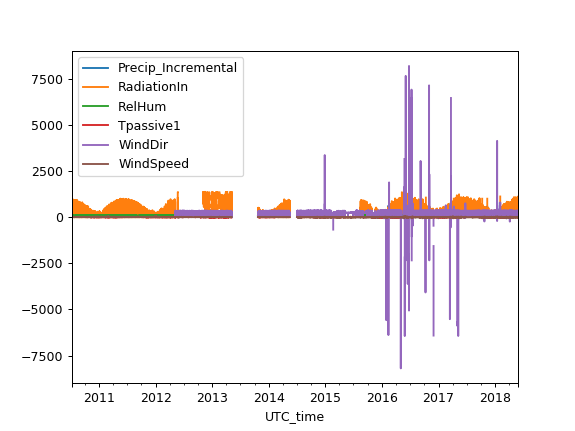

In [31]:
alldat.plot()

In [32]:
# #If there is hourly (not 15 min data)
# if Glacier + Station =='SouthCascade560':
#     start_15min_data='2014-05-15 15:15'
#     hourly_dat=alldat[:start_15min_data].copy()

#     full_range_15min = pd.date_range(hourly_dat.index[0], hourly_dat.index[-1], freq='15min')
#     hourly_dat=hourly_dat.reindex(index=full_range_15min, fill_value=pd.np.nan)

#     for col in hourly_dat.columns:
#         hourly_dat[col]=hourly_dat[col].interpolate(limit=3) #fill in 15 min vals from hourly, during time period not recorded

#     #Recombine with 15 minute logged data
#     new_dat=alldat[start_15min_data:].copy()
#     alldat=hourly_dat.append(new_dat)
#     alldat.drop(start_15min_data, inplace=True) #need this to drop the duplicate time @ the overlap point

In [33]:
alldat['time']=alldat.index
alldat['tdiff']=(alldat['time'].diff())

In [34]:
(alldat.tdiff > pd.to_timedelta('15M')).any()
alldat[(alldat.tdiff > pd.to_timedelta('15M'))]

,Precip_Incremental,RadiationIn,RelHum,Tpassive1,WindDir,WindSpeed,time,tdiff
UTC_time,,,,,,,,


In [35]:
#Reindex to 15 min; include missing dates
full_range_15minAll = pd.date_range(alldat.index[0], alldat.index[-1], freq='15min')
alldat=alldat.reindex(index=full_range_15minAll, fill_value=pd.np.nan)
#Create local time
#alldat['local_time'] = alldat.index.tz_localize('UTC').tz_convert(local_timezone)

In [36]:
#Wolverine River Stage Stuff
if Glacier + Station== 'Wolverine370':
    alldat[alldat.TipIncremental>1]=pd.np.nan

    #Fill forwards according to data type
    alldat.Tpassive1=alldat.Tpassive1.interpolate(limit=3) #comes as hourly; need to interpolate back to 15 min
    Null_to_keep=alldat.index[alldat.TipIncremental.isnull() & alldat.TipIncremental.shift(1).isnull() &alldat.TipIncremental.shift(-1).isnull()]
    alldat.TipIncremental=alldat.TipIncremental.fillna(value=0)
    alldat.loc[alldat.index.isin(Null_to_keep), 'TipIncremental']=pd.np.nan

    #Set uncertain precip data to NAN (pre 2005)
    alldat.loc[:'2004', 'TipIncremental']=pd.np.nan #Can't tell what is happening with these; huge #s, but don't seem to be simply cumulative? Change in units? Something else? Very hard to say.

    alldat['TipCumulative']=alldat.TipIncremental.cumsum()

    
#SouthCascade Stuff
if Glacier + Station=='SouthCascade560':
    alldat['Precip_Incremental']=alldat.Precip_Incremental/1000 #convert from mm to meters
    alldat['TipCumulative']=alldat.Precip_Incremental.cumsum()
  

In [37]:
#Time format stuff
date_format='%Y/%m/%d %H:%M'

#Set output format of time
alldat.index.tz='UTC'
alldat['UTC_time']=alldat.index.strftime(date_format)#Create column for true local time (as string, not UTC - X hrs)
alldat['local_time']=alldat.index.tz_convert(timezone).strftime(date_format)#Create column for true local time (as string, not UTC - X hrs)

out_col_order= ['UTC_time', 'local_time'] +data_columns
save_dat=alldat[out_col_order].copy()

#Ensure data does not have duplicates
save_dat.drop_duplicates(inplace=True)

In [38]:
save_dat.to_csv("NWIS_data_" + Glacier+ Station +".csv", index=False, float_format='%g')
print()

In [39]:
save_dat.head()

,UTC_time,local_time,Tpassive1,Precip_Incremental,WindSpeed,WindDir,RelHum,RadiationIn
2010-07-09 17:00:00+00:00,2010/07/09 17:00,2010/07/09 10:00,NaN,NaN,2.058,NaN,NaN,NaN
2010-07-09 17:15:00+00:00,2010/07/09 17:15,2010/07/09 10:15,NaN,NaN,1.500,NaN,NaN,NaN
2010-07-09 17:30:00+00:00,2010/07/09 17:30,2010/07/09 10:30,NaN,NaN,0.942,NaN,33.070,874.0
2010-07-09 17:45:00+00:00,2010/07/09 17:45,2010/07/09 10:45,NaN,NaN,1.529,NaN,33.785,888.5
2010-07-09 18:00:00+00:00,2010/07/09 18:00,2010/07/09 11:00,NaN,NaN,2.116,NaN,34.500,903.0


In [ ]:
save_dat.columns

In [ ]:
#Other plots and such

In [ ]:
# # Using figsize to make the figure a little bigger, 10"x5"
# fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False, figsize=(10,5))

# for ax in fig.axes:
#     plt.sca(ax)
#     plt.xticks(rotation=90)

# # Doing each of these manually (ugh)
# yr='2001'
# alldat.TipIncremental[yr].plot(ax=ax1)
# total_precip=alldat.TipIncremental[yr].cumsum()[alldat.TipIncremental[yr].cumsum().last_valid_index()]
# ax1.set_title(str(yr)+": total precip = "+ str(total_precip))

# yr='2002'
# alldat.TipIncremental[yr].plot(ax=ax2)
# total_precip=alldat.TipIncremental[yr].cumsum()[alldat.TipIncremental[yr].cumsum().last_valid_index()]
# ax2.set_title(str(yr)+": total precip = "+ str(total_precip))

# yr='2003'
# alldat.TipIncremental[yr].plot(ax=ax3)
# total_precip=alldat.TipIncremental[yr].cumsum()[alldat.TipIncremental[yr].cumsum().last_valid_index()]
# ax3.set_title(str(yr)+": total precip = "+ str(total_precip))

# yr='2004'
# alldat.TipIncremental[yr].plot(ax=ax4)
# total_precip=alldat.TipIncremental[yr].cumsum()[alldat.TipIncremental[yr].cumsum().last_valid_index()]
# ax4.set_title(str(yr)+": total precip = "+ str(total_precip))

# yr='2005'
# alldat.TipIncremental[yr].plot(ax=ax5)
# total_precip=alldat.TipIncremental[yr].cumsum()[alldat.TipIncremental[yr].cumsum().last_valid_index()]
# ax5.set_title(str(yr)+": total precip = "+ str(total_precip))

# yr='2007'
# alldat.TipIncremental[yr].plot(ax=ax6)
# total_precip=alldat.TipIncremental[yr].cumsum()[alldat.TipIncremental[yr].cumsum().last_valid_index()]
# ax6.set_title(str(yr)+": total precip = "+ str(total_precip))

# # df[df['Country'] == 'Iran'].plot(x='Year', y='GDP_per_capita', legend=False, ax=ax2)
# # ax2.set_title("Iran")
# # df[df['Country'] == 'France'].plot(x='Year', y='GDP_per_capita', legend=False, ax=ax3)
# # ax3.set_title("France")
# # df[df['Country'] == 'Ireland'].plot(x='Year', y='GDP_per_capita', legend=False, ax=ax4)
# # ax4.set_title("Ireland")
# # df[df['Country'] == 'Kazakhstan'].plot(x='Year', y='GDP_per_capita', legend=False, ax=ax5)
# # ax5.set_title("Kazakhstan")
# # df[df['Country'] == 'United Arab Emirates'].plot(x='Year', y='GDP_per_capita', legend=False, ax=ax6)
# # ax6.set_title("United Arab Emirates")

# # If you don't do tight_layout() you'll have weird overlaps
# plt.xticks(rotation=90)
# plt.tight_layout()

# #plt.savefig(r'Q:\Project Data\GlacierData\Benchmark_Program\Data\Wolverine\AllYears\Wx\Raw\telemeteredNWIS\Historical_1997to2017StreamGage\rawdataplots2001to2007.jpg') 

In [ ]:
# alldat.TipIncremental['2005-06-28 18':'2005-06-28 21']

In [ ]:
# alldat.loc[alldat.TipIncremental>50, 'TipIncremental']=pd.np.nan

In [ ]:
# alldat['month']=alldat.index.month
# alldat.month.isin([6,7,8,9])
# alldat.loc[~alldat.month.isin([6,7,8,9]), 'TipIncremental']=pd.np.nan

In [ ]:
#clean_increment=alldat.TipIncremental[alldat.TipIncremental.notnull()]['2002':]

In [ ]:
# plt.figure()
# ax=alldat.TipIncremental['2005-06-28 18':'2005-06-28 21'].cumsum().plot()
# #alldat.TipIncremental.cumsum(skipna=True).plot(marker='o', ms=3, color='red', ax=ax)
# #plt.legend(['From Cumulative File', 'From Incremental File'])
# plt.title("Full Record")

In [ ]:
plt.figure()
yr='2012'
alldat.TipIncremental[yr].cumsum().plot()
total_precip=alldat.TipIncremental[yr].cumsum()[alldat.TipIncremental[yr].cumsum().last_valid_index()]
plt.title(str(yr)+": total precip = "+ str(total_precip))

In [ ]:
# Using figsize to make the figure a little bigger, 10"x5"
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False, figsize=(10,5))

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)

# Doing each of these manually (ugh)
yr='2001'
alldat.TipIncremental[yr].cumsum().plot(ax=ax1)
total_precip=alldat.TipIncremental[yr].cumsum()[alldat.TipIncremental[yr].cumsum().last_valid_index()]
ax1.set_title(str(yr)+": total precip = "+ str(total_precip))

yr='2002'
alldat.TipIncremental[yr].cumsum().plot(ax=ax2)
total_precip=alldat.TipIncremental[yr].cumsum()[alldat.TipIncremental[yr].cumsum().last_valid_index()]
ax2.set_title(str(yr)+": total precip = "+ str(total_precip))

yr='2003'
alldat.TipIncremental[yr].cumsum().plot(ax=ax3)
total_precip=alldat.TipIncremental[yr].cumsum()[alldat.TipIncremental[yr].cumsum().last_valid_index()]
ax3.set_title(str(yr)+": total precip = "+ str(total_precip))

yr='2004'
alldat.TipIncremental[yr].cumsum().plot(ax=ax4)
total_precip=alldat.TipIncremental[yr].cumsum()[alldat.TipIncremental[yr].cumsum().last_valid_index()]
ax4.set_title(str(yr)+": total precip = "+ str(total_precip))

yr='2005'
alldat.TipIncremental[yr].cumsum().plot(ax=ax5)
total_precip=alldat.TipIncremental[yr].cumsum()[alldat.TipIncremental[yr].cumsum().last_valid_index()]
ax5.set_title(str(yr)+": total precip = "+ str(total_precip))

yr='2007'
alldat.TipIncremental[yr].cumsum().plot(ax=ax6)
total_precip=alldat.TipIncremental[yr].cumsum()[alldat.TipIncremental[yr].cumsum().last_valid_index()]
ax6.set_title(str(yr)+": total precip = "+ str(total_precip))

# df[df['Country'] == 'Iran'].plot(x='Year', y='GDP_per_capita', legend=False, ax=ax2)
# ax2.set_title("Iran")
# df[df['Country'] == 'France'].plot(x='Year', y='GDP_per_capita', legend=False, ax=ax3)
# ax3.set_title("France")
# df[df['Country'] == 'Ireland'].plot(x='Year', y='GDP_per_capita', legend=False, ax=ax4)
# ax4.set_title("Ireland")
# df[df['Country'] == 'Kazakhstan'].plot(x='Year', y='GDP_per_capita', legend=False, ax=ax5)
# ax5.set_title("Kazakhstan")
# df[df['Country'] == 'United Arab Emirates'].plot(x='Year', y='GDP_per_capita', legend=False, ax=ax6)
# ax6.set_title("United Arab Emirates")

# If you don't do tight_layout() you'll have weird overlaps
plt.xticks(rotation=90)
plt.tight_layout()

plt.savefig(r'Q:\Project Data\GlacierData\Benchmark_Program\Data\Wolverine\AllYears\Wx\Raw\telemeteredNWIS\Historical_1997to2017StreamGage\rawdataplots2001to2007.jpg') 

In [ ]:
# Using figsize to make the figure a little bigger, 10"x5"
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False, figsize=(10,5))

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)

# Doing each of these manually (ugh)
yr='2008'
alldat.TipIncremental[yr].cumsum().plot(ax=ax1)
total_precip=alldat.TipIncremental[yr].cumsum()[alldat.TipIncremental[yr].cumsum().last_valid_index()]
ax1.set_title(str(yr)+": total precip = "+ str(total_precip))

yr='2009'
alldat.TipIncremental[yr].cumsum().plot(ax=ax2)
total_precip=alldat.TipIncremental[yr].cumsum()[alldat.TipIncremental[yr].cumsum().last_valid_index()]
ax2.set_title(str(yr)+": total precip = "+ str(total_precip))

yr='2010'
alldat.TipIncremental[yr].cumsum().plot(ax=ax3)
total_precip=alldat.TipIncremental[yr].cumsum()[alldat.TipIncremental[yr].cumsum().last_valid_index()]
ax3.set_title(str(yr)+": total precip = "+ str(total_precip))

yr='2011'
alldat.TipIncremental[yr].cumsum().plot(ax=ax4)
total_precip=alldat.TipIncremental[yr].cumsum()[alldat.TipIncremental[yr].cumsum().last_valid_index()]
ax4.set_title(str(yr)+": total precip = "+ str(total_precip))

yr='2012'
alldat.TipIncremental[yr].cumsum().plot(ax=ax5)
total_precip=alldat.TipIncremental[yr].cumsum()[alldat.TipIncremental[yr].cumsum().last_valid_index()]
ax5.set_title(str(yr)+": total precip = "+ str(total_precip))

yr='2013'
alldat.TipIncremental[yr].cumsum().plot(ax=ax6)
total_precip=alldat.TipIncremental[yr].cumsum()[alldat.TipIncremental[yr].cumsum().last_valid_index()]
ax6.set_title(str(yr)+": total precip = "+ str(total_precip))

# df[df['Country'] == 'Iran'].plot(x='Year', y='GDP_per_capita', legend=False, ax=ax2)
# ax2.set_title("Iran")
# df[df['Country'] == 'France'].plot(x='Year', y='GDP_per_capita', legend=False, ax=ax3)
# ax3.set_title("France")
# df[df['Country'] == 'Ireland'].plot(x='Year', y='GDP_per_capita', legend=False, ax=ax4)
# ax4.set_title("Ireland")
# df[df['Country'] == 'Kazakhstan'].plot(x='Year', y='GDP_per_capita', legend=False, ax=ax5)
# ax5.set_title("Kazakhstan")
# df[df['Country'] == 'United Arab Emirates'].plot(x='Year', y='GDP_per_capita', legend=False, ax=ax6)
# ax6.set_title("United Arab Emirates")

# If you don't do tight_layout() you'll have weird overlaps
plt.xticks(rotation=90)
plt.tight_layout()

plt.savefig(r'Q:\Project Data\GlacierData\Benchmark_Program\Data\Wolverine\AllYears\Wx\Raw\telemeteredNWIS\Historical_1997to2017StreamGage\rawdataplots2008to2013.jpg') 

In [ ]:
# Using figsize to make the figure a little bigger, 10"x5"
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False, figsize=(10,5))

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)

# Doing each of these manually (ugh)
yr='2013'
alldat.TipIncremental[yr].cumsum().plot(ax=ax1)
total_precip=alldat.TipIncremental[yr].cumsum()[alldat.TipIncremental[yr].cumsum().last_valid_index()]
ax1.set_title(str(yr)+": total precip = "+ str(total_precip))

yr='2014'
alldat.TipIncremental[yr].cumsum().plot(ax=ax2)
total_precip=alldat.TipIncremental[yr].cumsum()[alldat.TipIncremental[yr].cumsum().last_valid_index()]
ax2.set_title(str(yr)+": total precip = "+ str(total_precip))

yr='2015'
alldat.TipIncremental[yr].cumsum().plot(ax=ax3)
total_precip=alldat.TipIncremental[yr].cumsum()[alldat.TipIncremental[yr].cumsum().last_valid_index()]
ax3.set_title(str(yr)+": total precip = "+ str(total_precip))

yr='2016'
alldat.TipIncremental[yr].cumsum().plot(ax=ax4)
total_precip=alldat.TipIncremental[yr].cumsum()[alldat.TipIncremental[yr].cumsum().last_valid_index()]
ax4.set_title(str(yr)+": total precip = "+ str(total_precip))

yr='2017'
alldat.TipIncremental[yr].cumsum().plot(ax=ax5)
total_precip=alldat.TipIncremental[yr].cumsum()[alldat.TipIncremental[yr].cumsum().last_valid_index()]
ax5.set_title(str(yr)+": total precip = "+ str(total_precip))

# df[df['Country'] == 'Iran'].plot(x='Year', y='GDP_per_capita', legend=False, ax=ax2)
# ax2.set_title("Iran")
# df[df['Country'] == 'France'].plot(x='Year', y='GDP_per_capita', legend=False, ax=ax3)
# ax3.set_title("France")
# df[df['Country'] == 'Ireland'].plot(x='Year', y='GDP_per_capita', legend=False, ax=ax4)
# ax4.set_title("Ireland")
# df[df['Country'] == 'Kazakhstan'].plot(x='Year', y='GDP_per_capita', legend=False, ax=ax5)
# ax5.set_title("Kazakhstan")
# df[df['Country'] == 'United Arab Emirates'].plot(x='Year', y='GDP_per_capita', legend=False, ax=ax6)
# ax6.set_title("United Arab Emirates")

# If you don't do tight_layout() you'll have weird overlaps
plt.xticks(rotation=90)
plt.tight_layout()

plt.savefig(r'Q:\Project Data\GlacierData\Benchmark_Program\Data\Wolverine\AllYears\Wx\Raw\telemeteredNWIS\Historical_1997to2017StreamGage\rawdataplots2013to2017.jpg') 

In [ ]:
alldat[['TipCumulative', 'TipIncremental', 'Tpassive1']].plot()
plt.ylim(-1, 300)

In [ ]:
alldat.head(1)

In [ ]:
dat1=pd.read_csv("Q:\Project Data\GlacierData\Benchmark_Program\Data\Wolverine\AllYears\Wx\Raw\StreamGage\wlca2_2015.csv", infer_datetime_format=True)

In [ ]:
dat1.head()

In [ ]:
precip=dat1.P_accum

In [ ]:
precip=precip.reset_index(drop=True)

In [ ]:
precip.head(5)

In [ ]:
plt.figure()
precip.dropna().plot()

In [ ]:
plt.figure()
alldat.TipIncremental.cumsum()['2015'].plot()